In [1]:
%matplotlib notebook

# Spectra

At the present, $LiMe$ does not have an inbuilt function to load spectra from a *.fits* files. Consequently, the user must write his/her own function to unpack the scientific data using [numpy](https://numpy.org/) and [astropy](https://www.astropy.org/).

As a guideline for novel astronomers (or Python programmers), in this tutorial, we are going to visit some examples on how to open spectra from well-known telescope instruments. You can find this page as a notebook in the [documentation/inputs folder](https://github.com/Vital-Fernandez/lime/tree/310d42ac507862a472c0bc14d291f216cb05e9d3/docs/source/documentation).

Any user, however, is encouraged to read the [FITS handling documentation](https://docs.astropy.org/en/stable/io/fits/index.html) carefully, to better manage their astronomical data. 

Independent of the observational range, there are a few things which could **dramatically** affect the quality of your measurements: 

#### Flux normalization:

In many cases, astronomical spectra is in C.G.S ([Centimetre–gram–second](https://en.wikipedia.org/wiki/Centimetre%E2%80%93gram%E2%80%93second_system_of_units)) units. This translates into a flux scale with very small numbers. This will make you fittings fail. If you input spectrum is not normalized it is essential you include a ``norm_flux`` in your ``lime.Spectrum`` and ``lime.Cube`` definition.

#### Wavelength units:

As in the case above, wavelength units (such as $\mu m$) may translate into pixel resolution steps $(\Delta \lambda)$ with very small magnitues. Your are recomended to use the ``.convert_units`` attribute.

#### Redshift:

$LiMe$ measurements are **performed and reported in the observed frame**. However, the default database and line labels are stored in the rest frame. This design was favoured to guarantee a uniform workflow in observational samples with different redshift values. Consequently, you are strongly encouraged to provide a ``redshift``.


## 1) Long-slit spectra

The reduced spectrum of a long-slit or echelle instrument, consists in a container for the photons flux and dispersion. The first array is stored directly on a file page but the latter, depending on the instrument, may need to be reconstructed from the page header keys.  

### a) OSIRIS instrument at the Gran Telescopio de Canarias

The long-slit spectra from this instruments follows the standard reduction using IRAF. Consequently, a page the wavelength array is computed from the ``CRVAL1``, ``CD1_1`` and ``NAXIS1`` keys.  

Let's start by importing the libraries we are going to use and declare the [folder](https://github.com/Vital-Fernandez/lime/tree/310d42ac507862a472c0bc14d291f216cb05e9d3/docs/source/tutorials/sample_data) with the scientific data:

In [2]:
import numpy as np
from astropy.io import fits
from pathlib import Path
from astropy.wcs import WCS
import lime

# Sample data location
spectra_path = Path('../sample_data')
fits_path = spectra_path/'gp121903_osiris.fits'
extension = 0

The extension above specifies the page from the *.fits* file, from which we read the data. A quick way to learn about the the extensions data you can use the [convenience function](https://docs.astropy.org/en/stable/io/fits/index.html#convenience-functions) ``fits.info``:

In [3]:
# Fits file information:
fits.info(fits_path)

Filename: ..\sample_data\gp121903_osiris.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (3199,)   float32   


In this file, there is only one extension, so we can now open the file:

In [4]:
# Open the fits file
with fits.open(fits_path) as hdul:
    flux_array, header = hdul[extension].data, hdul[extension].header

The code above we are using the [with context manager](https://realpython.com/python-with-statement/). This structure might be a confusing for the novel user. However, this design makes sure that the file is closed once we extract the data. This is safe practice in the case of large *.fits* files.

Now, we are going to compute the wavelength array:

In [5]:
# Reconstruct the wavelength array from the header data
w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
w_max = w_min + dw * n_pix
wave_array = np.linspace(w_min, w_max, n_pix, endpoint=False)
print(wave_array)

[ 3626.97753906  3629.04561139  3631.11368372 ... 10236.5367069
 10238.60477923 10240.67285156]


In this file the ``CRVAL1`` provides the spectrum lower limit wavelength, ``CD1_1`` states the wavelength resolution (constant for this instrument) and the integer ``NAXIS1`` is the number of pixels along the dispersion axis.

<div class="alert alert-info">

**Please remember:** The keys in a **.fits** header are not fully standarised. Make sure to check the keys description on the header data and the instrument documentation to confirm you are loading the files properly.

</div>

The units on the spectrum arrays should also be specified on the *.fits* header:


In [6]:
print(f'Wavelength array: {header["WAT1_001"]}')
print(f'Flux array: {header["BUNIT"]}')

Wavelength array: wtype=linear label=Wavelength units=Angstroms
Flux array: erg/cm2/s/A


Now we have all the data start analyzing this spectrum:

<IPython.core.display.Javascript object>


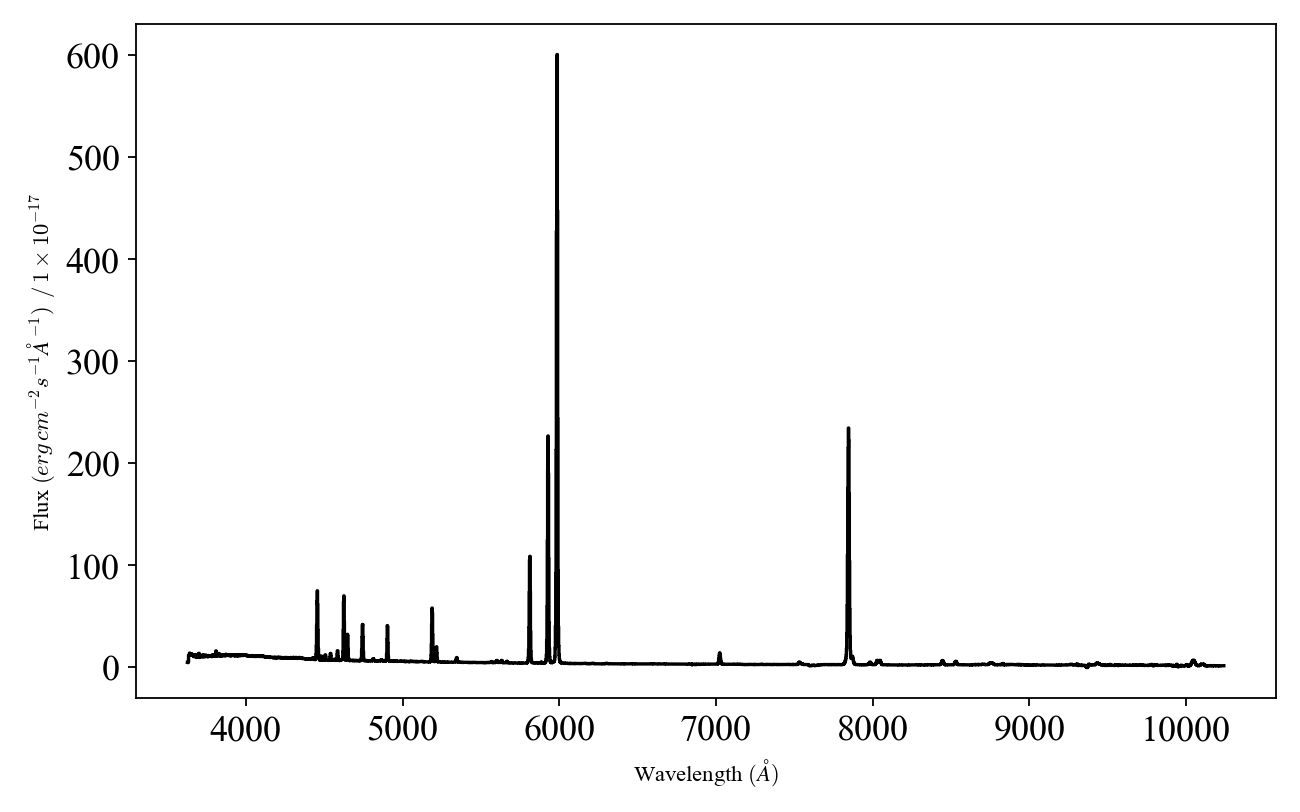

In [7]:
obj = lime.Spectrum(wave_array, flux_array, redshift=0.19531, norm_flux=1e-17)
obj.plot.spectrum()

### b) SDSS spectrum (data release 18)

The *.fits* files from [SDSS survey](https://skyserver.sdss.org/dr18/) are indexed following a dictionary-like structure which includes the wavelength array.

In [8]:
fits_path = spectra_path/'SHOC579_SDSS_dr18.fits'

To load the data we can use:

In [9]:
# Open the fits file
extension = 1
with fits.open(fits_path) as hdul:
    data = hdul[extension].data
    header = hdul[extension].header

The ``flux`` key indexes the flux. This value is normalized by $10^{-17}$:

In [10]:
flux_array = data['flux'] * 1e-17

The flux uncertainty is stored as the inversed of the variance. The bad values in this array are set to zero, hence, we are going to mask these values to compute the error spectrum.

In [11]:
ivar_array = data['ivar']
pixel_mask = ivar_array == 0

In [12]:
err_array = np.sqrt(1/np.ma.masked_array(ivar_array, pixel_mask)) * 1e-17

Finally, the wavelength array is stored in logarithmic scale and they are accessed via the ``loglam`` key:

In [13]:
wave_vac_array = np.power(10, data['loglam'])

This wavelength array is in vacuum. To convert it to air units we can use the [Morton (1991, ApJS, 77, 119)](https://ui.adsabs.harvard.edu/abs/1991ApJS...77..119M/abstract) law:

In [14]:
wave_array = wave_vac_array / (1.0 + 2.735182E-4 + 131.4182 / wave_vac_array**2 + 2.76249E8 / wave_vac_array**4)

Now we can create the ``Spectrum`` object:

<IPython.core.display.Javascript object>


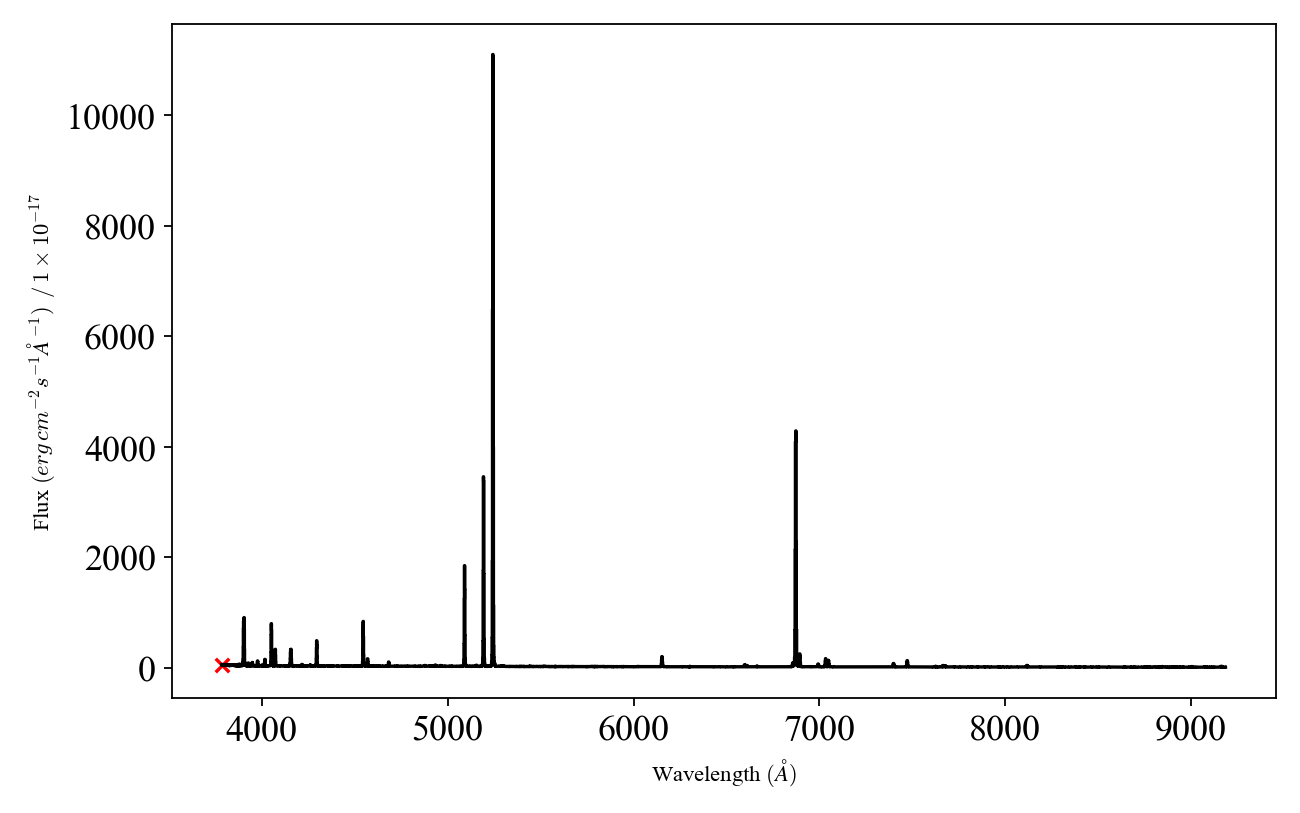

In [15]:
obj = lime.Spectrum(wave_array, flux_array, err_array, pixel_mask=pixel_mask, norm_flux=1e-17, redshift=0.0475)
obj.plot.spectrum()

## 2) IFU data sets

Integrated Field provide a cube data array, whose depthness edge corresponds to the dispersion axis. The other two axes provide the spatial coordinates. Depending of the instrument, the size of these files can be very large and 3rd party libraries are necessary to open such files.

### a) MANGA survey cubes

As we did in the case of the SDSS survey, we are opening an observation from the SHOC579 galaxy, which we are also analysing in the [4th tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/notebook4_IFU_Spatial_Masking.html). 

In [16]:
fits_path = spectra_path/'manga-8626-12704-LOGCUBE.fits.gz'

This file is comprossed, however, the ``astropy.io.fits.open`` can read compressed files. However, loading compressed file is slower than an uncompressed one:

In [17]:
# Open the MANGA cube fits file
with fits.open(fits_path) as hdul:

    # Wavelength 1D array
    wave = hdul['WAVE'].data

    # Flux 3D array
    flux_cube = hdul['FLUX'].data * 1e-17

    # Convert inverse variance cube to standard error, masking 0-value pixels first
    ivar_cube = hdul['IVAR'].data
    pixel_mask_cube = ivar_cube == 0
    pixel_mask_cube = pixel_mask_cube.reshape(ivar_cube.shape)
    err_cube = np.sqrt(1/np.ma.masked_array(ivar_cube, pixel_mask_cube)) * 1e-17

    # Header
    hdr = hdul['FLUX'].header

The header of *.fits* spectra usually contains the astronomical coordinates of the observation. $LiMe$ relies on astropy [World Coordidnate System](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) function, to plot the IFU data and export the coordinates to the output *.fits* with your measurements:

You can create the WCS object from your information from the data on the observation header:

In [18]:
# WCS from the observation
wcs = WCS(hdr)

a string value was expected. [astropy.wcs.wcs]


Now, we have all the create our Cube object:

In [19]:
cube = lime.Cube(wave, flux_cube, err_cube, redshift=0.0475, norm_flux=1e-17, pixel_mask=pixel_mask_cube)

LiMe WARNING: Your wave array does not include a pixel mask this can caused issues on the fittings
LiMe WARNING: Your wave_rest array does not include a pixel mask this can caused issues on the fittings


Now you can extract individual spaxels to analyse the object lines. Each spaxel will have its corresponding error spectrum and pixel mask

<IPython.core.display.Javascript object>


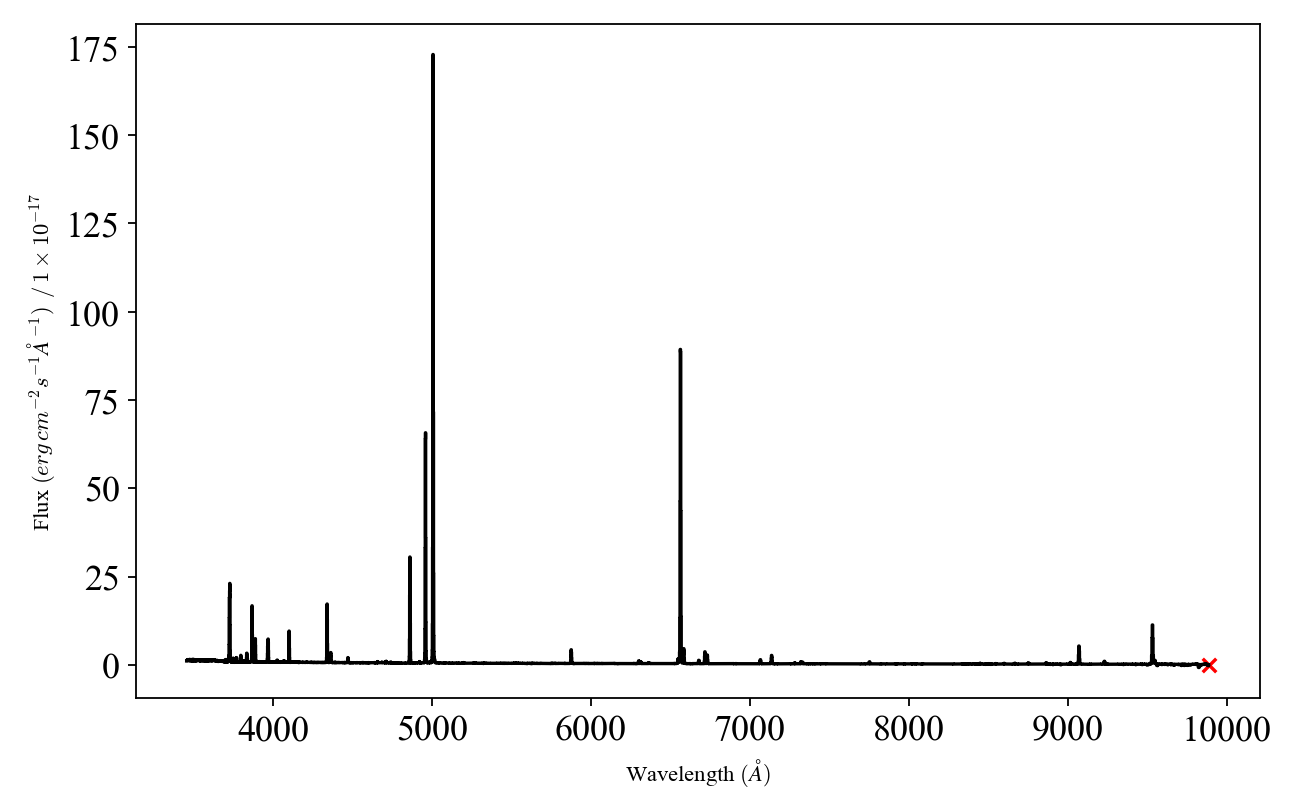

In [20]:
# Extract spaxel
spaxel = cube.get_spectrum(38, 35)

# Plot spectrum
spaxel.plot.spectrum(rest_frame=True)

Finally, we can perform measurements on this spaxel using the ``Spectrum`` attributes

<IPython.core.display.Javascript object>


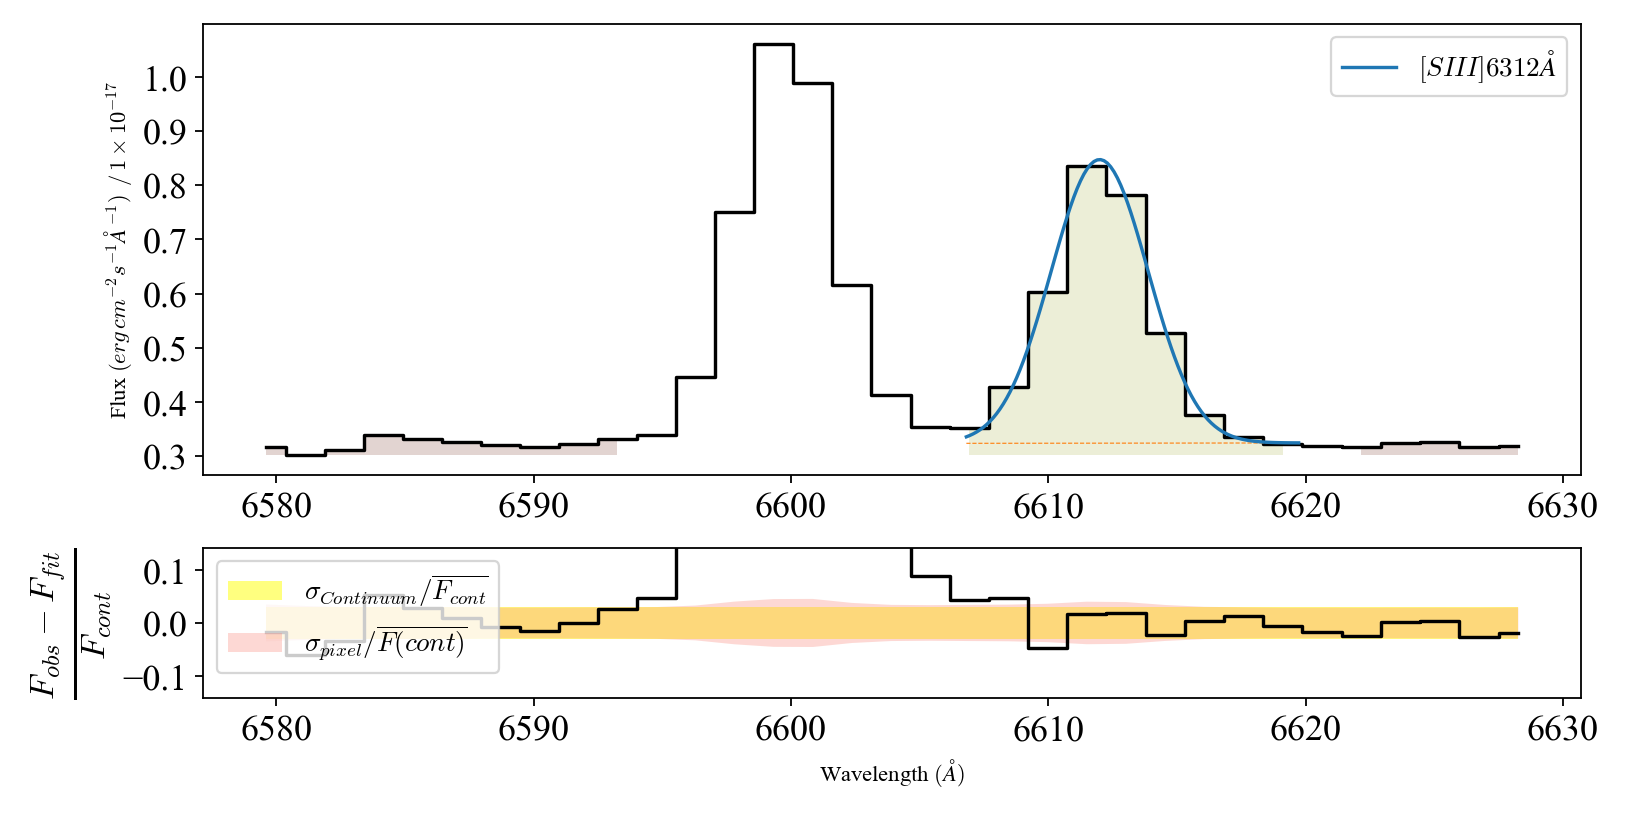

In [21]:
# Fit emission line using the bands from the default database
spaxel.fit.bands('S3_6312A')

# Plot last fitting
spaxel.plot.bands()